# NSDUH Drug Sequence Analysis Part 8:  Gateway Hypothesis Analysis
## Matthew J. Beattie
## University of Oklahoma
__February 26, 2021__

### Gateway Hypothesis Analysis
This analysis uses the labeled dataset from Step 6 to probe on the large non-Gateway cluster and on the polyabuse clusters.

### Approach
* Read in the labeled partitioned dataset
* Use basic pathway frequency analyses from Step 1

In [1]:
"""
Import python modules
"""
import pandas as pd
import numpy as np
import copy
import os
import sys
import pathlib, itertools
import time
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import random
import pickle
import json
import pathutils as pu
import mlflow
import profile
import gc
import csv
from math import dist, sqrt
import networkx as nx


HOME_DIR = pathlib.Path.home()
CW_DIR = pathlib.Path.cwd()

FIGW = 12
FIGH = 5
FONTSIZE = 8
FIGURESIZE = (FIGW,FIGH)

plt.rcParams['figure.figsize'] = (FIGW, FIGH)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE


### Set file names, etc.

In [2]:
# Set working parameters
datapath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Data3/'
workingpath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Code3/'
outpath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Output3/'
hugefiles = 'C:/Users/mjbea/huge_files/'
year = '2016_2017_2018_2019'
jsondict = datapath + 'NSDUH_field.json'
n_clusters = 13
alpha = 0.60

# Setup filenames
newclustpkl =  workingpath + 'stable_13_clust_2016_2017_2018_2019_newclust.pkl'

# Get translation dictionaries
stryear = '2016_2017_2018_2019'

# Drug name and indices are called by a user-defined function.
ident, rawafuvals, afuvals, drugnames, drugorder, drugnums, drugposition, startdemog, demographics = pu.surveyvars(year)

# Decode dictionaries for NSDUH variables:
f1 = open(jsondict, 'r')
nsduhDecoder = json.load(f1)
f1.close()


### Helper Utilities
These methods calculate cluster stats such as inertia, average inertia, center of cluster, and nearest medoid to center, and a descriptive AFU path that characterizes the medoid.

In [3]:

"""
getcenter(df)
Calculates and returns the center and inertia of a cluster.  Uses weights from survey.
"""
def getcenter(df):
    df['AFUARRAY'] = df.apply(lambda row: np.matrix(row['AFUVECT']).A[0],axis=1)
    center = np.average(a=df['AFUARRAY'], weights=df['YRWEIGHT'])
    df['DISTSQ'] = df.apply(lambda row: euclidean(row['AFUARRAY'],center)**2, axis=1)
    df['WTDISTSQ'] = df.apply(lambda row: row['DISTSQ'] * row['YRWEIGHT'], axis=1)
    inertia = df['WTDISTSQ'].sum()
    return center, inertia


"""
getmedoid(df)
Calculates and returns medoid of a cluster
"""
def getmedoid(df, clustcenter):
#    clustcenter, clustinertia = getcenter(df)
    df['distfrommean'] = df.apply(lambda row: euclidean(np.matrix(row['AFUVECT']).A[0], clustcenter), axis=1)
    medoidstr = df.loc[df['distfrommean'].idxmin()]['AFUVECT']
    medoid = np.matrix(medoidstr).A[0]
    return medoid


"""
arrayToPath(medoid)
Converts a medoid to a path list
"""
def arrayToPath(array):
    afupath = {}
    i = 0
    for item in array:
        pathstep = {drugposition[i]: float(item)}   # The type conversion is necessary for saving in JSON
        if item != 991:
            afupath.update(pathstep)
        i += 1
    return afupath


"""
makenewpath(df, drugposition)
Recreates the AFUPATH variable from the AFUVECT variable
"""
def makenewpath(df, drugposition):
    vect = []
    i = 0
    for position in df['AFUVECT']:
        if position < 991:
            vect.append((drugposition[i], position))
        i += 1
        vect.sort(key=lambda x:x[1])
    return vect


"""
makeunwnewpath(df, drugposition)
Recreates the AFUPATH variable from the AFUVECT variable
"""
def makeunwnewpath(df, drugposition):
    vect = []
    for position in df['AFUPATH']:
        vect.append(position[0])
    return vect


In [4]:
# Read in labeled data file
nsduh = pd.read_pickle(newclustpkl)
nsduh['AFUPATH'] = nsduh.apply(lambda row: makenewpath(row, drugposition), axis=1)
nsduh['UNWAFUPATH'] = nsduh.apply(lambda row: makeunwnewpath(row, drugposition), axis=1)
print('Shape of nsduh:', nsduh.shape)
print('Total population:', nsduh['YRWEIGHT'].sum())

# Create dataframe of cluster 1
clust1 = nsduh[nsduh['newlabels']==1]
print(clust1.value_counts('newlabels'))

# Create polyabuse dataframe (clusters 4,6,8,11)
polyuse = nsduh[nsduh['newlabels'].isin([4,6,8,11])]
print(polyuse.value_counts('newlabels'))

Shape of nsduh: (170944, 20)
Total population: 247716947.40132222
newlabels
1    44917
dtype: int64
newlabels
4     11125
6      6332
8      5527
11     2950
dtype: int64


In [5]:
nsduh.head()

,RESPID,AFUVECT,labels,CATAG6,SVCFLAG,IRSEX,IRMARIT,NEWRACE2,EDUHIGHCAT,IRWRKSTAT,GOVTPROG,INCOME,COUTYP4,AIIND102,YRWEIGHT,origcenter,newlabels,newcenter,AFUPATH,UNWAFUPATH
0,201611635143.0,"[0, 16, 15, 20, 991, 991, 991, 991, 991, 991]",3,3,0,2,1,1,4,4,2,4,3,2,204.858562,"[0.0, 16.389404642865316, 16.65761675165035, 1...",1,"[0.0, 16.238233053523604, 36.34497839137807, 1...","[(start, 0), (ALCOHOL, 15), (TOBACCO, 16), (MA...","[start, ALCOHOL, TOBACCO, MARIJUANA]"
1,201661056143.0,"[0, 21, 15, 15, 991, 991, 991, 991, 991, 991]",3,4,0,1,1,7,1,1,1,3,2,2,26.197423,"[0.0, 16.389404642865316, 16.65761675165035, 1...",1,"[0.0, 16.238233053523604, 36.34497839137807, 1...","[(start, 0), (ALCOHOL, 15), (MARIJUANA, 15), (...","[start, ALCOHOL, MARIJUANA, TOBACCO]"
2,201683666143.0,"[0, 18, 18, 20, 991, 991, 991, 991, 991, 991]",3,3,0,2,1,1,4,1,2,4,2,2,198.317305,"[0.0, 16.389404642865316, 16.65761675165035, 1...",1,"[0.0, 16.238233053523604, 36.34497839137807, 1...","[(start, 0), (TOBACCO, 18), (ALCOHOL, 18), (MA...","[start, TOBACCO, ALCOHOL, MARIJUANA]"
3,201659497143.0,"[0, 22, 16, 20, 991, 991, 991, 991, 991, 991]",3,2,0,1,4,7,3,1,2,2,1,2,472.577706,"[0.0, 16.389404642865316, 16.65761675165035, 1...",1,"[0.0, 16.238233053523604, 36.34497839137807, 1...","[(start, 0), (ALCOHOL, 16), (MARIJUANA, 20), (...","[start, ALCOHOL, MARIJUANA, TOBACCO]"
4,201663899143.0,"[0, 14, 16, 15, 991, 991, 991, 991, 991, 991]",3,3,0,1,4,2,2,1,1,1,3,2,783.607113,"[0.0, 16.389404642865316, 16.65761675165035, 1...",1,"[0.0, 16.238233053523604, 36.34497839137807, 1...","[(start, 0), (TOBACCO, 14), (MARIJUANA, 15), (...","[start, TOBACCO, MARIJUANA, ALCOHOL]"


In [6]:
# ********** THE FOLLOWING CODE BLOCKS ARE FROM STEP 1 ***************

# Generate a dataframe containing all of the different edges and their frequency
# This block takes the edges in the paths for each row and stores them and their row weight
afuGraphDF = clust1[['RESPID','YRWEIGHT','AFUPATH']]
edgelist = []
for row in afuGraphDF.itertuples():
    path = row.AFUPATH
    if len(path)==1:
#        edgelist.append([(path[0][0],'NONE'),row.YRWEIGHT])
        edgelist.append([('start','NONE'),row.YRWEIGHT])
    else:
        for i in range(0,len(path)-1):
            edgelist.append([(path[i][0],path[i+1][0]),row.YRWEIGHT])

# This block summarizes the counts of the edges
edgelistdf = pd.DataFrame (edgelist, columns = ['edge','weight'])
edgelistdf = edgelistdf.groupby('edge').sum('weight').sort_values(by='weight', ascending=False)
totaledges = edgelistdf['weight'].sum()
edgelistdf['fraction'] = edgelistdf['weight']/totaledges
edgelistdf.reset_index(inplace=True)

In [7]:
print('The number of total edges is', totaledges)
print('The number of unique edges is', edgelistdf.shape[0])
edgelistdf.head()

The number of total edges is 203418077.39755836
The number of unique edges is 47


,edge,weight,fraction
0,"(start, TOBACCO)",3.762096e+07,0.184944
1,"(ALCOHOL, MARIJUANA)",3.573839e+07,0.175689
2,"(TOBACCO, ALCOHOL)",3.206506e+07,0.157631
3,"(TOBACCO, MARIJUANA)",2.065731e+07,0.101551
4,"(start, ALCOHOL)",1.930995e+07,0.094927


In [8]:
# Print out edges to output
filename = outpath + 'gateway_edges_and_paths.txt'
fileout = open(filename, 'w')
print('EDGELIST ENUMERATION', file=fileout)
print('The total number of edges is:', totaledges, file=fileout)
print('The total number of unique edges is:', edgelistdf.shape[0], file=fileout)
totfrac = 0
for row in edgelistdf.itertuples():
    totfrac += row.fraction
    print(row.edge, '\t', round(row.weight,0), '\t', round(row.fraction,6), '\t', round(totfrac,6), file=fileout)


In [9]:
# Print summary to standard out
print('The number of total edges is', totaledges)
print('The number of unique edges is', edgelistdf.shape[0])
edgelistdf.head()

The number of total edges is 203418077.39755836
The number of unique edges is 47


,edge,weight,fraction
0,"(start, TOBACCO)",3.762096e+07,0.184944
1,"(ALCOHOL, MARIJUANA)",3.573839e+07,0.175689
2,"(TOBACCO, ALCOHOL)",3.206506e+07,0.157631
3,"(TOBACCO, MARIJUANA)",2.065731e+07,0.101551
4,"(start, ALCOHOL)",1.930995e+07,0.094927


In [10]:
# Generate a dataframe containing all of the different paths and their frequency
# This block takes the the paths for each row and stores them and their row weight
afuGraphDF = clust1[['RESPID','YRWEIGHT','UNWAFUPATH']]
pathlist = []
for row in afuGraphDF.itertuples():
    path = str(row.UNWAFUPATH)
    pathlist.append([path,row.YRWEIGHT])

# This block summarizes the counts of the edges
pathlistdf = pd.DataFrame (pathlist, columns = ['path','weight'])
pathlistdf = pathlistdf.groupby('path').sum('weight').sort_values(by='weight', ascending=False)
totalpaths = pathlistdf['weight'].sum()
pathlistdf['fraction'] = pathlistdf['weight']/totalpaths
pathlistdf.reset_index(inplace=True)

In [11]:
print('The number of total paths is', totalpaths)
print('The number of unique paths is', pathlistdf.shape[0])
pathlistdf.head()

The number of total paths is 62456795.18458987
The number of unique paths is 178


,path,weight,fraction
0,"['start', 'TOBACCO', 'ALCOHOL', 'MARIJUANA']",2.152204e+07,0.344591
1,"['start', 'ALCOHOL', 'TOBACCO', 'MARIJUANA']",9.186485e+06,0.147085
2,"['start', 'TOBACCO', 'MARIJUANA', 'ALCOHOL']",5.425603e+06,0.086870
3,"['start', 'ALCOHOL', 'MARIJUANA', 'TOBACCO']",4.937063e+06,0.079048
4,"['start', 'TOBACCO', 'ALCOHOL', 'MARIJUANA', '...",3.159945e+06,0.050594


In [12]:
# Print the most common paths
print('\n\n\nMOST COMMON PATHS', file=fileout)
print('The total number of paths is:', totalpaths, file=fileout)
print('The total number of unique is:', pathlistdf.shape[0], file=fileout)
totfrac = 0
for row in pathlistdf.itertuples():
    totfrac += row.fraction
    if totfrac <= 0.9:
        print(row.path, '\t', round(row.weight,0), '\t', round(row.fraction,6), '\t', round(totfrac,6), file=fileout)

fileout.close()

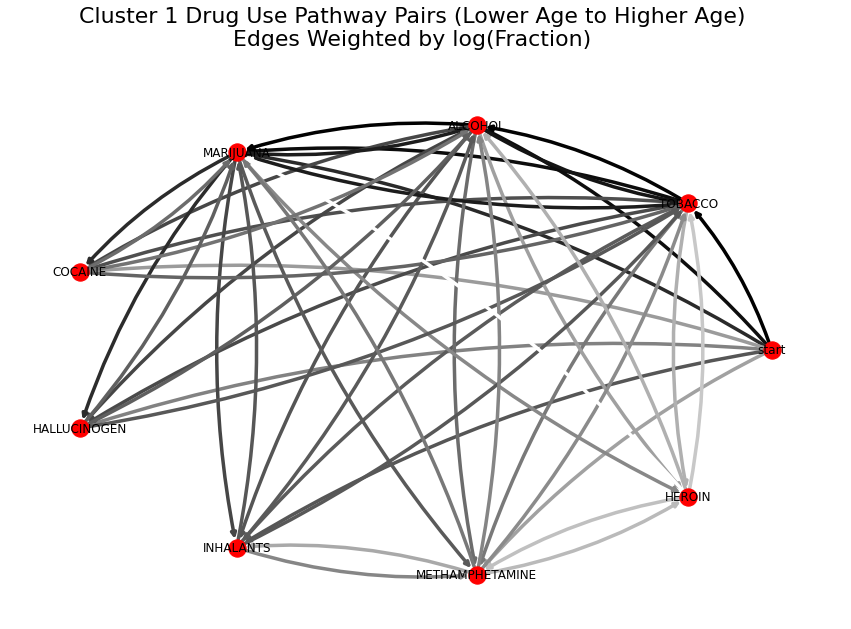

In [13]:
# Visualize edges with NetworkX
# Add columns to fit NetworkX format:  node1, node2, attributes.  Take log fraction to improve graphing
def getnode(row, index):
    return row.edge[index]

edgelistdf['node1'] = edgelistdf.apply(lambda row: getnode(row, 0), axis=1)
edgelistdf['node2'] = edgelistdf.apply(lambda row: getnode(row, 1), axis=1)
edgelistdf['logfrac'] = np.log(edgelistdf['fraction'])
edgelistdf.head()

# Read the pandas edgelist into NetworkX
G = nx.from_pandas_edgelist(edgelistdf, source='node1', target='node2', edge_attr=['fraction','logfrac'],create_using=nx.DiGraph())

# Draw the graph with darker colors for heavier weights
edges,weights = zip(*nx.get_edge_attributes(G,'logfrac').items())

figname = outpath + 'gateway_drugpair_graph.jpg'
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
fig.suptitle('Cluster 1 Drug Use Pathway Pairs (Lower Age to Higher Age)\nEdges Weighted by log(Fraction)', fontsize=22)
pos = nx.circular_layout(G)
nx.draw(G, pos, node_color='r', edgelist=edges, edge_color=weights, width=3.5, edge_cmap=plt.cm.binary, 
        connectionstyle='arc3, rad = 0.1', ax=ax1)
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif", ax=ax1)
plt.savefig(figname)
plt.show()
